# Import Libraries and Setting Configuration

In [1]:
# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Configuration
from IPython.display import clear_output
np.set_printoptions(linewidth=np.inf)

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import time
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras import Model, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications import MobileNet
from keras.applications import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub
import requests

# Mencetak versi TensorFlow yang sedang digunakan
print(f"Tensorflow Version : {tf.__version__}")
print(f"keras Version      : {keras.__version__}")
print([device for device in tf.config.list_physical_devices()][0])
print([device for device in tf.config.list_physical_devices()][1])

Tensorflow Version : 2.13.0
keras Version      : 2.13.1
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Loading

## Load Data

In [7]:
# Windows Path
dataset_path = "../Dataset/Animal Image Dataset/"

## Create Animal Dictionary

In [8]:
animal_dict = {}
for label in os.listdir(dataset_path):
    animal_dict[label] = os.listdir(os.path.join(dataset_path, label))

## Check Labels

In [4]:
# Print Bold
def bold (text):
    return "\033[1m" + str(text) + '\033[0m'

# Print Dataset Info
print(f"Dataset has {bold(len(animal_dict.keys()))} labels : {[label for label in animal_dict.keys()]}")
print(f"Total Images : {bold(sum([len(value) for value in animal_dict.values()]))}")

Dataset has 12 labels : ['butterfly', 'cats', 'cow', 'dogs', 'elephant', 'hen', 'horse', 'monkey', 'panda', 'sheep', 'spider', 'squirrel']
Total Images : 17178


## Plotting 3 Random Image from Each Class

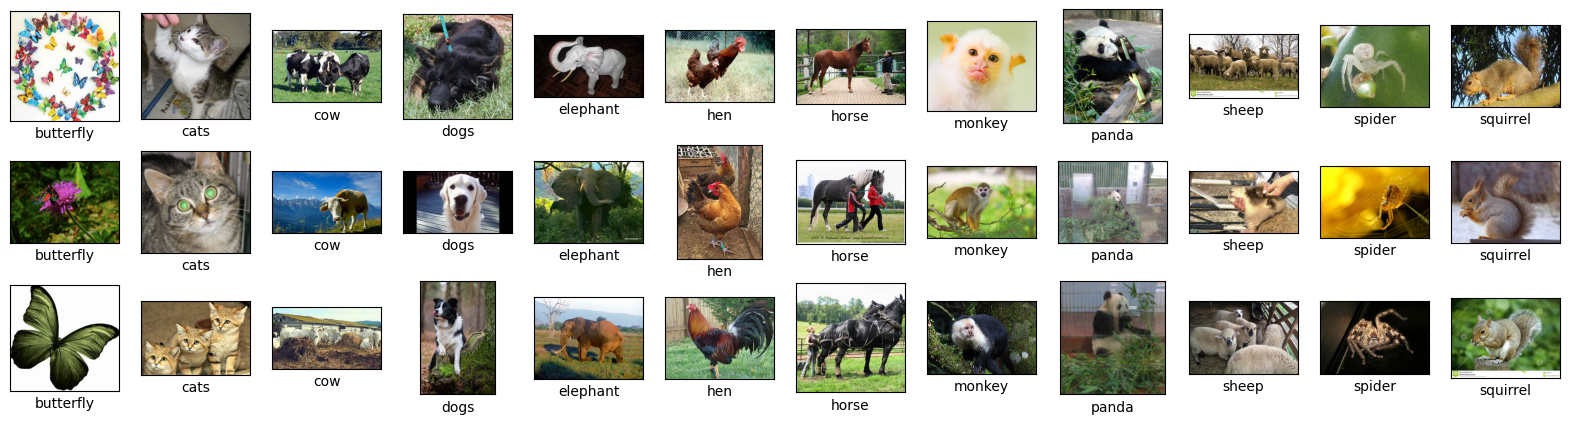

In [5]:
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(3, len(animal_dict.keys()), figsize=(20, 5))

for i, label in enumerate(animal_dict.keys()):
    images = np.random.choice(animal_dict[label], 3, replace=False)
    
    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, label, image_name)
        img = Image.open(img_path)
        axs[j, i].imshow(img)
        axs[j, i].set(xlabel=label, xticks=[], yticks=[])

## Plotting Data Distribution

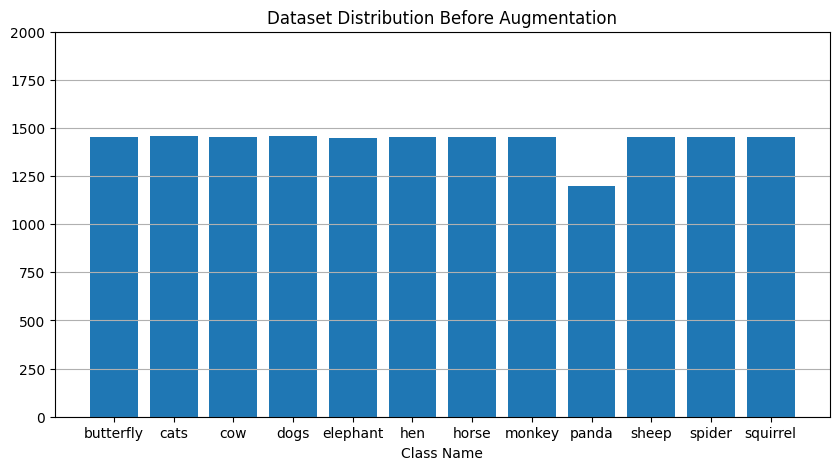

In [6]:
data_label, data_count = [], []
for key, value in animal_dict.items():
    data_label.append(key)
    data_count.append(len(value))
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(axis='y')
ax.bar(data_label, data_count)
ax.set_ylim(0, 2000)
ax.set_xlabel('Class Name')
ax.set_title('Dataset Distribution Before Augmentation')
plt.show()

# Data Augmentation

## Augmentation Function Declaration

In [7]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)
 
# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)
 
# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)
 
# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img
 
# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)
 
# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image
 
# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

## Function Dictionary

In [8]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

## Apply Augmentation

In [9]:
for key, value in animal_dict.items():
    # print(len(value), key)
    images_path = os.path.join(dataset_path, key)
    augmented_path = images_path
    images = []
    
    for image in os.listdir(images_path):
        images.append(os.path.join(images_path, image))
        
    images_to_generate = 1500
    i = len(value) + 1
    
    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)

            # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
            if original_image.ndim not in [3, 4]:
                raise ValueError('Invalid image dimensions')

            transformed_image = None
            n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
            transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

            while n <= transformation_count:
                aug_func = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
                clear_output(wait=True)
                print(key)
                print(aug_func)
                print(image)
                time.sleep(0.00001)
                transformed_image = transformations[aug_func](original_image)
                n = n + 1

            new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
            transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
            cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
            i = i + 1
        except ValueError as e:
            print('Failed', aug_func, image, ':', e, 'hence skipping it.')

squirrel
add brightness
../Dataset/Animal Image Dataset/squirrel/OIP-LYs2AohYuTX1S_mkVvljnAAAAA.jpeg


## Plotting Data Distribution

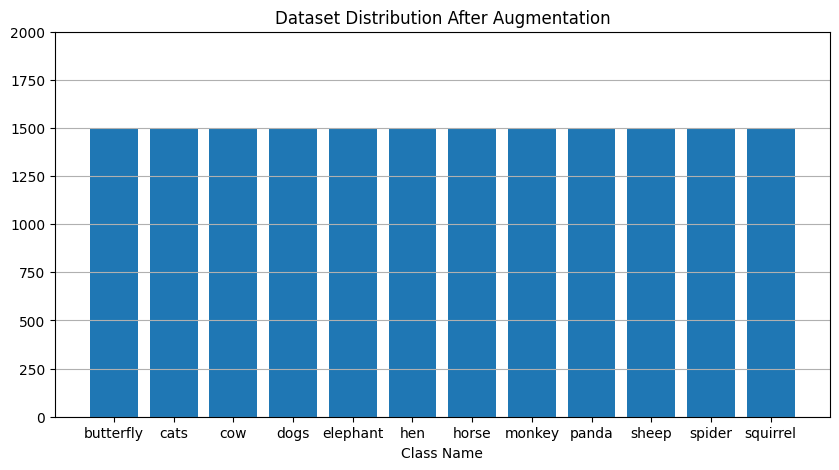

In [11]:
# Update Animal Dictionary
for label in os.listdir(dataset_path):
    animal_dict[label] = os.listdir(os.path.join(dataset_path, label))

# Distributuin Plot
data_label, data_count = [], []
for key, value in animal_dict.items():
    data_label.append(key)
    data_count.append(len(value))
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(axis='y')
ax.bar(data_label, data_count)
ax.set_ylim(0, 2000)
ax.set_xlabel('Class Name')
ax.set_title('Dataset Distribution After Augmentation')
plt.show()

# Image Data Generator

## Define Function imageGenerator

In [9]:
def imageGenerator(path, IMG_SIZE, BATCH_SIZE, cMode, vsplit):
    datagen = ImageDataGenerator(
        rescale = 1/255.,           # Normalization
        validation_split = vsplit      # Validation Split = 20%
    )

    X_train = datagen.flow_from_directory(
        path,
        batch_size=BATCH_SIZE,
        target_size=(IMG_SIZE,IMG_SIZE),
        color_mode=cMode,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    X_valid = datagen.flow_from_directory(
        path,
        batch_size=BATCH_SIZE,
        target_size=(IMG_SIZE,IMG_SIZE),
        color_mode=cMode,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )
    return X_train, X_valid

# Model

## Callbacks

In [40]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
            self.model.stop_training=True
            print('\nModel telah mencapai akurasi 95%')

## Define Model

### Load Pretrained Model

In [14]:
model_inceptionV3 = InceptionV3(
     weights='imagenet',
    include_top=False,
    input_shape=(299,299,3)   
)

# freeze layers inception
for layer in model_inceptionV3.layers:
    layer.trainable = False
    
model_inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

### Add Custom Layer and Output Layer

In [41]:
# Reset Session
# tf.keras.backend.clear_session()

# Adding Layers
class_num = len(animal_dict.keys())
inceptionV3 = Sequential([
    model_inceptionV3,
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    # Output Layer
    Dense(class_num, activation='softmax')
])

# Compile Model
inceptionV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

inceptionV3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 128)         2359424   
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                        

### Load Data from Generator

In [10]:
X_train, X_valid = imageGenerator(
    path=dataset_path,
    IMG_SIZE=299,
    BATCH_SIZE=32,
    cMode="rgb",
    vsplit=0.2
)

Found 14400 images belonging to 12 classes.
Found 3600 images belonging to 12 classes.


### Training Model

In [42]:
epoch_num = 100
callbacks = [myCallback()]
history = inceptionV3.fit(
    X_train, 
    epochs=epoch_num,
    validation_data=X_valid,
    callbacks=callbacks
)

Epoch 1/100
450/450 [==============================] - 193s 416ms/step - loss: 2.2618 - accuracy: 0.2617 - val_loss: 1.8243 - val_accuracy: 0.6478
Epoch 2/100
450/450 [==============================] - 182s 405ms/step - loss: 1.5608 - accuracy: 0.6111 - val_loss: 1.1702 - val_accuracy: 0.8253
Epoch 3/100
450/450 [==============================] - 183s 407ms/step - loss: 1.0722 - accuracy: 0.7606 - val_loss: 0.7729 - val_accuracy: 0.8956
Epoch 4/100
450/450 [==============================] - 168s 372ms/step - loss: 0.8072 - accuracy: 0.8215 - val_loss: 0.5750 - val_accuracy: 0.9222
Epoch 5/100
450/450 [==============================] - 183s 406ms/step - loss: 0.6417 - accuracy: 0.8608 - val_loss: 0.4552 - val_accuracy: 0.9358
Epoch 6/100
450/450 [==============================] - 206s 458ms/step - loss: 0.5418 - accuracy: 0.8803 - val_loss: 0.3812 - val_accuracy: 0.9397
Epoch 7/100
450/450 [==============================] - 251s 559ms/step - loss: 0.4753 - accuracy: 0.8934 - val_loss: 0

## Plotting Akurasi dan Loss

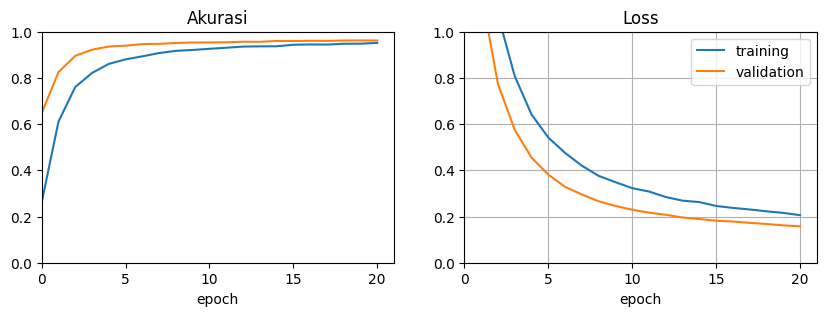

In [44]:
epoch_num = 21
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].set(xlabel='epoch', title="Akurasi", xlim=(0,epoch_num), ylim=(0,1))
axs[0].plot(history.history["accuracy"], label="training")
axs[0].plot(history.history["val_accuracy"], label="validation")

axs[1].set(xlabel='epoch', title="Loss", xlim=(0,epoch_num), ylim=(0,1))
axs[1].plot(history.history["loss"], label="training")
axs[1].plot(history.history["val_loss"], label="validation")
plt.grid()
plt.legend()

In [45]:
eva = inceptionV3.evaluate(X_valid)
print(f"Model Evaluasi (Akurasi) : {eva[1]*100:.2f}%")
print(f"Model Evaluasi (loss)    : {eva[0]*100:.2f}%")

113/113 [==============================] - 37s 325ms/step - loss: 0.1578 - accuracy: 0.9619
Model Evaluasi (Akurasi) : 96.19%
Model Evaluasi (loss)    : 15.78%


## Save Model

### SavedModel Format

In [56]:
save_path = './models/inceptionV3/1/'
tf.saved_model.save(inceptionV3, save_path)

INFO:tensorflow:Assets written to: ./models/inceptionV3/1/assets


INFO:tensorflow:Assets written to: ./models/inceptionV3/1/assets


### Convert Model to TensorflowJS

In [2]:
# Convert SavedModel to tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model './models/inceptionV3/1/' /tfjs_model

### Convert Model to Tensorflow Lite

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/inceptionV3/1/')
tflite_model = converter.convert()

os.makedirs('./tflite', exist_ok=True)
tflite_model_file = pathlib.Path('./tflite/vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

96646620

# Inference with Tensorflow Serving

## Create Labels Dictionary

In [13]:
%time sum(range(1000000))

labels = {}
for key,value in X_valid.class_indices.items():
    labels[value] = key                             # Reverse key and value in label dictionary
labels

CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 12.5 ms


{0: 'butterfly',
 1: 'cats',
 2: 'cow',
 3: 'dogs',
 4: 'elephant',
 5: 'hen',
 6: 'horse',
 7: 'monkey',
 8: 'panda',
 9: 'sheep',
 10: 'spider',
 11: 'squirrel'}

In [100]:
# %time sum(range(1000000))

def inference(file):
    endpoint = "http://localhost:8501/v1/models/inception:predict"
    
    image = tf.io.decode_image(open(file, 'rb').read(), channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image/255.
   
    image_tensor = tf.expand_dims(image, 0)
    image_tensor = image_tensor.numpy().tolist()
    
    json_data = { "instances": image_tensor }
    response = requests.post(endpoint, json=json_data)

    predict = response.json()['predictions'][0]

    return  print("Gambar adalah : {}, dengan score {} %".format(labels[np.argmax(predict)], np.max(predict)*100))

filename = './img/butterfly_test_01.png'
y_pred = inference(file=filename)

Gambar adalah : butterfly, dengan score 99.9989271 %
